# Demo notebook

In [ ]:
from pathlib import Path
import os, json, math, datetime as dt, pathlib
from shapely.geometry import Point, box, mapping
from shapely.ops import transform
from pystac_client import Client
from datetime import datetime, timezone
import requests, tqdm
import rasterio

In [2]:
!pip install -q s2cloudless

### S2 data download

In [3]:
from s2_data.s2_utils import point_buffer_bbox, get_item_dt_utc, download_asset, plot_s2_truecolor

In [25]:
from s2_data.cloud_utils import _reproject_geom, plot_scl_map, find_asset_key, reproject_geom, scl_metrics, count_cloud_pixels

ImportError: cannot import name 'count_cloud_pixels' from 's2_data.cloud_utils' (/Users/martasumyk/Desktop/HyperRes/hyperspectral_super-resolution/s2_data/cloud_utils.py)

In [5]:
LAT = 48.3794
LON = 43.1656
DATE = "2024-06-04"
DAYS_BEFORE = 5
DAYS_AFTER  = 5
SEARCH_BUFFER_M = 5000

In [6]:
BASE = Path("data")
S2_DIR   = BASE / "sentinel2"
S2_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
start = (dt.datetime.fromisoformat(DATE) - dt.timedelta(days=DAYS_BEFORE)).date().isoformat()
end   = (dt.datetime.fromisoformat(DATE) + dt.timedelta(days=DAYS_AFTER)).date().isoformat()
time_range = f"{start}/{end}"

print("Time range:", time_range)

Time range: 2024-05-30/2024-06-09


In [8]:
ROI = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
ROI_BBOX = ROI.bounds
ROI_GEOJSON = mapping(ROI)

In [9]:
S2_API = "https://earth-search.aws.element84.com/v1"
S2_COLLECTION = "sentinel-2-l2a"

In [10]:
s2_client = Client.open(S2_API)

In [11]:
s2_search = s2_client.search(
    collections=[S2_COLLECTION],
    datetime=time_range,
    intersects=ROI_GEOJSON,
    limit=20
)

In [12]:
s2_items = list(s2_search.get_items())

s2_items

/Users/martasumyk/Desktop/HyperRes/hyperspectral_super-resolution/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


[<Item id=S2B_37UGP_20240605_0_L2A>,
 <Item id=S2B_38ULU_20240605_0_L2A>,
 <Item id=S2A_37UGP_20240531_0_L2A>,
 <Item id=S2A_38ULU_20240531_0_L2A>]

In [13]:
chosen_date = datetime.fromisoformat(DATE).replace(tzinfo=timezone.utc)


best = sorted(
    s2_items,
    key=lambda it: abs((get_item_dt_utc(it) - chosen_date).total_seconds())
)[0]


In [14]:
best

<Item id=S2B_38ULU_20240605_0_L2A>

In [15]:
assets = best.assets
dl_paths = []

In [16]:
if "visual" in assets:
    href = assets["visual"].href
    out = S2_DIR / f"{best.id}_visual.tif"
    download_asset(href, out)
    dl_paths.append(out)
else:
    for b in ("B04", "B03", "B02"):
        if b in assets:
            href = assets[b].href
            out = S2_DIR / f"{best.id}_{b}.tif"
            download_asset(href, out)
            dl_paths.append(out)

print("Downloaded:", [str(p) for p in dl_paths])

S2B_38ULU_20240605_0_L2A_visual.tif: 100%|██████████| 277M/277M [02:18<00:00, 2.01MB/s] 

Downloaded: ['data/sentinel2/S2B_38ULU_20240605_0_L2A_visual.tif']


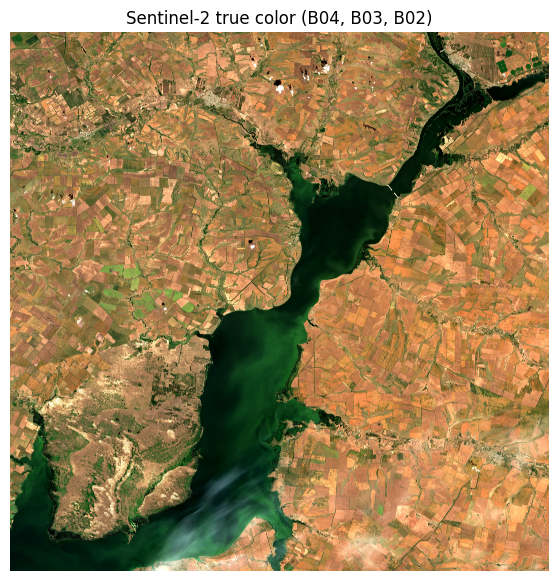

array([[[0.47179778, 0.39433845, 0.17604396],
        [0.47179778, 0.40842194, 0.18308571],
        [0.48588127, 0.39433845, 0.20421098],
        ...,
        [0.52813182, 0.51404832, 0.24646152],
        [0.49292309, 0.47883953, 0.24646152],
        [0.51404832, 0.49292309, 0.22533625]],

       [[0.48588127, 0.40842194, 0.22533625],
        [0.49996483, 0.3872967 , 0.21125272],
        [0.47179778, 0.3872967 , 0.20421098],
        ...,
        [0.59150766, 0.54221537, 0.27462857],
        [0.54221537, 0.53517363, 0.26758679],
        [0.52109007, 0.51404832, 0.22533625]],

       [[0.48588127, 0.4225055 , 0.18308571],
        [0.51404832, 0.41546375, 0.22533625],
        [0.49996483, 0.40138019, 0.19012745],
        ...,
        [0.59150766, 0.52813182, 0.28871206],
        [0.58446591, 0.53517363, 0.27462857],
        [0.57038242, 0.53517363, 0.27462857]],

       ...,

       [[0.        , 0.07745934, 0.04225054],
        [0.        , 0.0845011 , 0.0492923 ],
        [0.        , 0

In [17]:
plot_s2_truecolor(dl_paths)

### Filtering by cloudness level

In [18]:
s2_search = s2_client.search(
    collections=[S2_COLLECTION],
    datetime=time_range,
    intersects=ROI_GEOJSON,
    limit=20,
    query={"eo:cloud_cover": {"lt": 50}}  # filter for cloudness < 50%
)

s2_items = list(s2_search.get_items())
print(f"Found {len(s2_items)} S2 candidates with <50% clouds")

print(s2_items)

Found 2 S2 candidates with <50% clouds
[<Item id=S2B_37UGP_20240605_0_L2A>, <Item id=S2B_38ULU_20240605_0_L2A>]


Download cloud mask:

In [19]:
print(best.id)
print(sorted(best.assets.keys()))

S2B_38ULU_20240605_0_L2A
['aot', 'aot-jp2', 'blue', 'blue-jp2', 'coastal', 'coastal-jp2', 'granule_metadata', 'green', 'green-jp2', 'nir', 'nir-jp2', 'nir08', 'nir08-jp2', 'nir09', 'nir09-jp2', 'red', 'red-jp2', 'rededge1', 'rededge1-jp2', 'rededge2', 'rededge2-jp2', 'rededge3', 'rededge3-jp2', 'scl', 'scl-jp2', 'swir16', 'swir16-jp2', 'swir22', 'swir22-jp2', 'thumbnail', 'tileinfo_metadata', 'visual', 'visual-jp2', 'wvp', 'wvp-jp2']


In [24]:
clean_candidates = []
for item in tqdm.tqdm(s2_items, desc="Checking cloud pixels"):

    key = find_asset_key(item.assets, ["scl", "scl-jp2"])
    asset = item.assets[key]
    url = asset.href

    # Save with correct extension
    ext = Path(url).suffix or (".tif" if key == "scl" else ".jp2")
    scl_path = S2_DIR / f"{item.id}_SCL{ext}"

    if not scl_path.exists():
        download_asset(url, scl_path)

    try:
        clouds, total = count_cloud_pixels(str(scl_path), ROI)
    except rasterio.errors.RasterioIOError as e:
        continue

    cloud_frac = (clouds / total) if total > 0 else 1.0
    print(f"{item.id}: clouds={clouds}, total={total}, frac={cloud_frac:.4f}")

    if clouds == 0:
        clean_candidates.append(item)

print(f"\nFound {len(clean_candidates)} fully cloud-free:")
for it in clean_candidates:
    print(" -", it.id)


Checking cloud pixels: 100%|██████████| 2/2 [00:00<00:00, 56.71it/s]

S2B_37UGP_20240605_0_L2A: clouds=0, total=158813, frac=0.0000
S2B_38ULU_20240605_0_L2A: clouds=0, total=249915, frac=0.0000

Found 2 fully cloud-free:
 - S2B_37UGP_20240605_0_L2A
 - S2B_38ULU_20240605_0_L2A
